In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parameters
a  = .02
b  = .2
c  = -50
d  = 2

v = -65      # Initial values of v
u = b*v      # Initial values of u

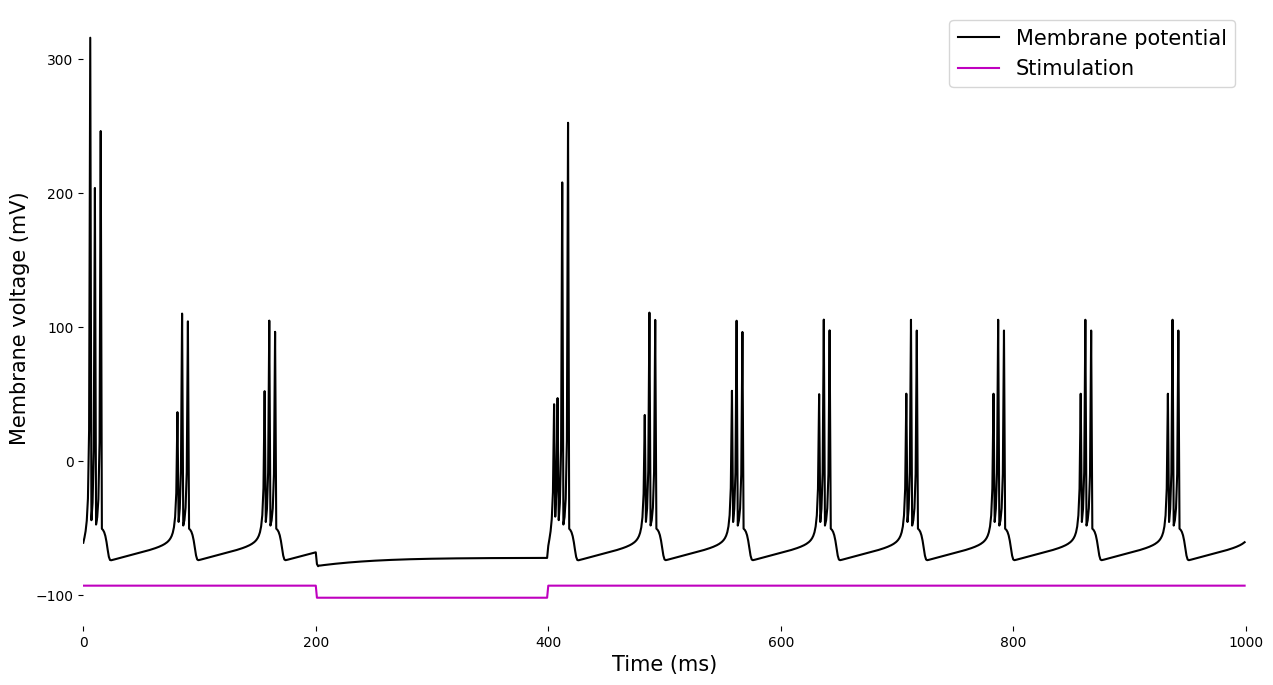

In [3]:
# initializations
simulation_time = 1000
memvolt = np.zeros(simulation_time)
Iall = np.zeros(simulation_time)


# loop through simulation time
for t in range(simulation_time):

  # define exogenous input strength
  I = -2 if (t>200) & (t<400) else 7
  #I = 6*np.random.rand()
  
  # check if action potential and update
  if v >= 30:
    v = c
    u += d
  
  # update membrane voltage
  v += .04*v**2 + 5*v + 140 - u + I
  u += a*(b*v-u)
  
  # collect variables for plotting
  memvolt[t] = v
  Iall[t] = I


fig,ax = plt.subplots(1,figsize=(15,8))
plt.plot(memvolt,'k',label='Membrane potential')
plt.plot(Iall-100,'m',label='Stimulation')
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Membrane voltage (mV)',fontsize=15)
plt.box(False)
plt.xlim([0,simulation_time])
plt.legend(fontsize=15)
plt.show()

In [5]:
# Excitatory neurons                 Inhibitory neurons
Ne = 800;                            Ni = 200
re = np.random.rand(Ne);             ri = np.random.rand(Ni)

#               excitatory           inhibitory
a = np.hstack((.02*np.ones(Ne),     .02+.08*ri))
b = np.hstack((.2*np.ones(Ne),      .25-.05*ri))
c = np.hstack((-65+15*re**2,        -65*np.ones(Ni)))
d = np.hstack((8-6*re**2,            2*np.ones(Ni)))

# initial values of v and u
v = -65*np.ones(Ne+Ni)
u = b*v

# matrix of all-to-all synaptic weights
S = np.hstack((.5*np.random.rand(Ne+Ni,Ne), -np.random.rand(Ne+Ni,Ni) ))

In [6]:
# initializations
simulation_time = 5000
firings = np.array([[],[]])

# loop through simulation time
for t in range(simulation_time):

  # define random exogenous input strength (different for E and I cells)
  I = np.hstack((5*np.random.randn(Ne),2*np.random.randn(Ni)))
  # I = np.hstack((5*np.ones(Ne),2*np.ones(Ni)))
  
  # check if action potential and update
  fired   = np.where(v>=30)[0]
  tmp     = np.stack((np.tile(t,len(fired)),fired))
  firings = np.concatenate((firings,tmp),axis=1)

  # update membrane variables for cells that fired
  v[fired] = c[fired]
  u[fired] = u[fired] + d[fired]

  # update membrane variables for down-stream cells
  I += np.sum(S[:,fired],axis=1)
  
  # update membrane voltage
  v += .04*v**2 + 5*v + 140 - u + I
  u += a*(b*v-u)

In [7]:
print(firings.shape)
firings

(2, 41271)


array([[4.000e+00, 5.000e+00, 5.000e+00, ..., 4.999e+03, 4.999e+03,
        4.999e+03],
       [8.600e+01, 4.920e+02, 7.130e+02, ..., 5.430e+02, 6.340e+02,
        9.090e+02]])

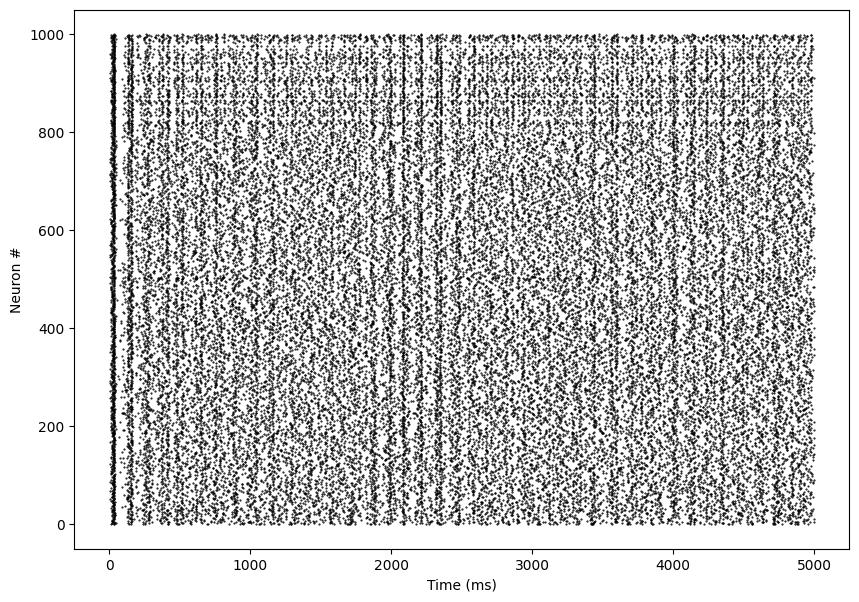

In [8]:
# visualize
fig,ax = plt.subplots(1,figsize=(10,7))

plt.plot(firings[0,:],firings[1,:],'k.',markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
# plt.xlim([1000,2000])
plt.show()

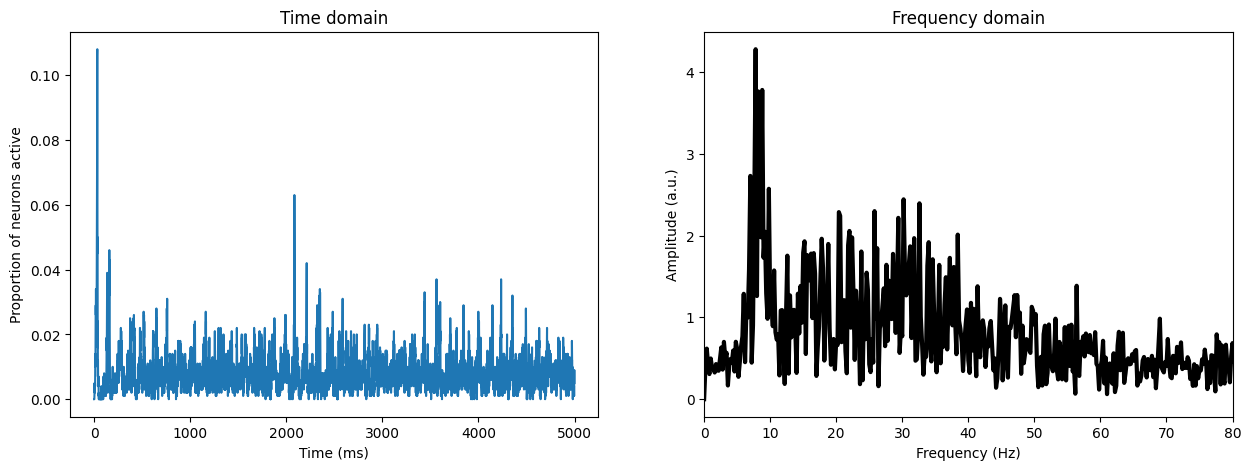

In [9]:
# population spiking activity
popact = np.zeros(simulation_time)

# loop over time and find the units that spiked at that time
for ti in range(simulation_time):
  popact[ti] = np.sum(firings[0,:]==ti) / (Ne+Ni)


fig,ax = plt.subplots(1,2,figsize=(15,5))

# time-domain plot
ax[0].plot(popact)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Proportion of neurons active')
ax[0].set_title('Time domain')
# ax[0].set_xlim([1000,1500])
# ax[0].set_ylim([0,.1])


# frequency-domain plot
popactX = np.abs(np.fft.fft(popact-np.mean(popact)))
hz = np.linspace(0,500,int(simulation_time/2+1))

ax[1].plot(hz,popactX[:len(hz)],'k',linewidth=3)
ax[1].set_xlim([0,80])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (a.u.)')
ax[1].set_title('Frequency domain')

plt.show()

In [10]:
# a function to run the network

def simCircuit(I):
  
  # initializations
  firings = np.array([[],[]])

  # initial values of v and u
  v = -65*np.ones(Ne+Ni)
  u = b*v

  # loop through simulation time
  for t in range(len(I)):

    # stimulation for each neuron
    stim = np.hstack((4*np.random.randn(Ne),1*np.random.randn(Ni))) + I[t]
    
    # check if action potential and update
    fired   = np.where(v>=30)[0]
    tmp     = np.stack((np.tile(t,len(fired)),fired))
    firings = np.concatenate((firings,tmp),axis=1)

    # update membrane variables for cells that fired
    v[fired] = c[fired]
    u[fired] = u[fired] + d[fired]
    
    # update membrane variables for down-stream cells
    stim += np.sum(S[:,fired],axis=1)
    
    # update membrane voltage
    v += .04*v**2 + 5*v + 140 - u + stim
    u += a*(b*v-u)

  return firings

In [11]:
# a function to visualize the results

def plotPopActivity(firings):
  # max number of time points
  npnts = int(np.max(firings[0,:])+1) # +1 b/c starts at 0

  # population spiking activity
  popact = np.zeros(npnts)
  for ti in range(npnts):
    popact[ti] = np.sum(firings[0,:]==ti) / (Ne+Ni)

  # amplitude spectrum
  popactX = np.abs(np.fft.fft(popact-np.mean(popact)))
  hz = np.linspace(0,500,int(npnts/2+1))

  # time-domain plot
  fig,ax = plt.subplots(1,3,figsize=(20,5))
  ax[0].plot(firings[0,:],firings[1,:],'k.',markersize=1)
  ax[0].plot(I*50+100,'m',linewidth=2)
  ax[0].set_xlabel('Time (ms)')
  ax[0].set_ylabel('Neuron #')
  ax[0].set_title('Population spiking')
  
  ax[1].plot(popact)
  ax[1].set_xlabel('Time (ms)')
  ax[1].set_ylabel('Proportion of neurons active')
  ax[1].set_title('Time domain')

  ax[2].plot(hz,popactX[:len(hz)],'k',linewidth=3)
  ax[2].set_xlim([0,80])
  ax[2].set_xlabel('Frequency (Hz)')
  ax[2].set_ylabel('Amplitude (a.u.)')
  ax[2].set_title('Frequency domain')
  plt.show()

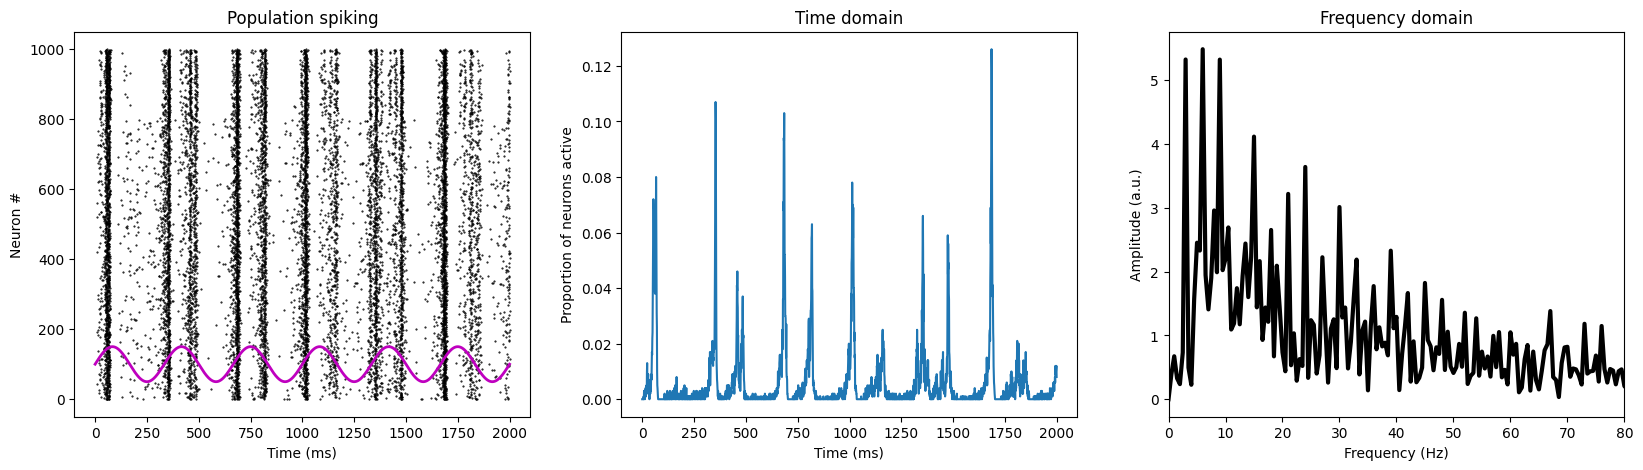

In [12]:
# now for the experiments...

# create some inputs

# option 1
I = np.ones(1234)
I[400:601] = -2

# option 2
I = (np.linspace(-2,2,3001))**2

# # option 3
I = np.sin(np.linspace(0,6*np.pi,2000)*2)


# run the simulation and plot the results
networkspikes = simCircuit(I)
plotPopActivity(networkspikes)